In [1]:
# -------------------------------------------------------------------
# Proyecto de Computación Evolutiva
# Optimización Evolutiva de Asignación de Pedidos (Dataset LADE)
# -------------------------------------------------------------------
# Este proyecto implementa un algoritmo evolutivo multiobjetivo,
# basado en NSGA-II, para abordar el problema de asignación de pedidos
# a repartidores en servicios de entrega bajo demanda.
#
# Se utiliza el dataset LADE (Large-scale Dataset for Delivery),
# específicamente el archivo pickup_yt.csv, que contiene información
# real de pedidos en el punto de recogida, incluyendo datos temporales
# y coordenadas geográficas.
#
# El problema se modela como un problema de asignación, donde cada
# solución candidata representa una posible asignación de pedidos a
# un conjunto fijo de repartidores. No se utiliza la asignación real
# del dataset (courier_id), ya que el objetivo es optimizar dicha
# asignación mediante técnicas evolutivas.
#
# El algoritmo NSGA-II permite optimizar simultáneamente múltiples
# objetivos en conflicto, entre ellos:
#   - Minimizar el tiempo total estimado de atención de los pedidos.
#   - Minimizar la distancia total asociada a los pedidos asignados.
#   - Minimizar el desbalance de carga entre repartidores.
#
# Debido al gran tamaño del dataset LADE, se trabaja con subconjuntos
# de datos definidos por ventanas de tiempo y/o regiones específicas,
# lo que permite construir instancias manejables del problema.
#
# Como resultado, el proyecto obtiene un conjunto de soluciones no
# dominadas (frente de Pareto), que representan distintos compromisos
# entre los objetivos considerados, permitiendo analizar alternativas
# eficientes de asignación de pedidos.
# -------------------------------------------------------------------


In [2]:
# Instala las librerías necesarias para el proyecto:
# - pymoo: implementación de algoritmos evolutivos y multiobjetivo (ej. NSGA-II)
# - pandas: manipulación y análisis de datos tabulares (dataset LADE)
# - numpy: operaciones numéricas y manejo de arreglos
# - matplotlib: visualización de resultados, como el frente de Pareto
!pip install pymoo pandas numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.9 MB/s eta 0:00:00


In [3]:
#versiones fijadas
!pip install -q datasets==2.21.0 huggingface_hub==0.24.6 pyarrow pandas==2.2.2 fsspec==2024.6.1



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.24.6 which is incompatible.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.24.6 which is incompatible.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.24.6 which is incompatible.
peft 0.18.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.24.6 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [4]:
!pip -q install datasets==2.21.0 huggingface_hub==0.24.6 fsspec==2024.6.1 aiohttp


In [5]:
import os
os.environ["HF_HUB_ETAG_TIMEOUT"] = "120"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"


In [6]:
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="Cainiao-AI/LaDe",
    repo_type="dataset",
    local_dir="LaDe_local",
    local_dir_use_symlinks=False,
    resume_download=True,
    max_workers=2
)

print("Dataset descargado en:", local_dir)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1212: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a 

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

courier_detailed_trajectory.zip:   0%|          | 0.00/160M [00:00<?, ?B/s]

courier_detailed_trajectory_20s.pkl.xz:   0%|          | 0.00/439M [00:00<?, ?B/s]

delivery_five_cities.pkl.xz:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

pickup_five_cities.pkl.xz:   0%|          | 0.00/41.3M [00:00<?, ?B/s]

delivery_cq.csv:   0%|          | 0.00/145M [00:00<?, ?B/s]

delivery_hz.csv:   0%|          | 0.00/287M [00:00<?, ?B/s]

delivery_jl.csv: 0.00B [00:00, ?B/s]

delivery_sh.csv:   0%|          | 0.00/228M [00:00<?, ?B/s]

delivery_yt.csv:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

delivery_five_cities.csv:   0%|          | 0.00/136M [00:00<?, ?B/s]

LaDe.png:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

pickup_cq.csv:   0%|          | 0.00/191M [00:00<?, ?B/s]

pickup_hz.csv:   0%|          | 0.00/336M [00:00<?, ?B/s]

pickup_jl.csv:   0%|          | 0.00/43.8M [00:00<?, ?B/s]

pickup_sh.csv:   0%|          | 0.00/228M [00:00<?, ?B/s]

pickup_yt.csv:   0%|          | 0.00/190M [00:00<?, ?B/s]

pickup_five_cities.csv:   0%|          | 0.00/154M [00:00<?, ?B/s]

roads.csv:   0%|          | 0.00/232M [00:00<?, ?B/s]

Dataset descargado en: /content/LaDe_local


In [7]:
#ver con detalle el dataset descaragado
!find /content/LaDe_local -maxdepth 3 -type d


/content/LaDe_local
/content/LaDe_local/road-network
/content/LaDe_local/img
/content/LaDe_local/pickup
/content/LaDe_local/data_with_trajectory_20s
/content/LaDe_local/delivery
/content/LaDe_local/.cache
/content/LaDe_local/.cache/huggingface
/content/LaDe_local/.cache/huggingface/download


# ------------------------------------------------------------
# Dataset: LADE (Large-scale Dataset for Delivery)
# ------------------------------------------------------------
# Este proyecto utiliza el dataset LADE, un conjunto de datos
# a gran escala publicado por Cainiao-AI para investigación en
# problemas de logística y servicios de entrega bajo demanda.
#
# El dataset contiene información real de pedidos, incluyendo:
# - Datos de recogida (pickup) en restaurantes o comercios
# - Datos de entrega (delivery) a clientes finales
# - Información de trayectorias de repartidores (opcional)
# - Red vial (road-network) para análisis avanzados
#
# Para este trabajo se utiliza únicamente el archivo:
#   /content/LaDe_local/pickup/pickup_yt.csv
#
# Este archivo contiene los pedidos en el punto de recogida,
# con información temporal y geográfica suficiente para modelar
# el problema de asignación de pedidos a repartidores.
#
# Debido al gran tamaño del dataset completo, se trabaja con
# subconjuntos del archivo (por ventanas de tiempo) para construir
# instancias manejables del problema de optimización evolutiva.
#
# Las demás carpetas del dataset (delivery, road-network y
# data_with_trajectory_20s) no se utilizan en esta implementación,
# ya que exceden el alcance del presente proyecto.
# ------------------------------------------------------------


In [8]:
import pandas as pd

df = pd.read_csv(
    "/content/LaDe_local/pickup/pickup_yt.csv",
    low_memory=False
)

df.head()


,order_id,region_id,city,courier_id,accept_time,time_window_start,time_window_end,lng,lat,aoi_id,aoi_type,pickup_time,pickup_gps_time,pickup_gps_lng,pickup_gps_lat,accept_gps_time,accept_gps_lng,accept_gps_lat,ds
0,4732519,16,Yantai,992,05-18 08:16:00,05-18 09:00:00,05-18 11:00:00,121.21661,36.77277,32,1,05-18 08:42:00,05-18 08:42:00,121.22029,36.77386,05-18 08:10:00,121.21800,36.77443,518
1,5411237,16,Yantai,992,05-14 09:17:00,05-14 13:00:00,05-14 15:00:00,121.21923,36.77317,32,1,05-14 12:40:00,05-14 12:40:00,121.22033,36.77403,05-14 09:16:00,121.21094,36.78368,514
2,143142,16,Yantai,992,05-10 15:30:00,05-10 15:30:00,05-10 17:30:00,121.22025,36.77384,32,1,05-10 15:54:00,05-10 15:54:00,121.22032,36.77409,05-10 15:29:00,121.22023,36.77399,510
3,3421498,16,Yantai,992,05-05 12:47:00,05-05 12:47:00,05-05 14:47:00,121.21676,36.77269,32,1,05-05 13:50:00,05-05 13:50:00,121.22058,36.77391,NaN,NaN,NaN,505
4,362894,16,Yantai,992,05-11 08:02:00,05-11 09:00:00,05-11 11:00:00,121.22031,36.77385,32,1,05-11 09:04:00,05-11 09:03:00,121.22030,36.77395,05-11 07:58:00,121.21808,36.77453,511


In [9]:
print("✅ CSV recargado. Filas:", len(df))
df[["accept_time"]].head()

✅ CSV recargado. Filas: 1146781


,accept_time
0,05-18 08:16:00
1,05-14 09:17:00
2,05-10 15:30:00
3,05-05 12:47:00
4,05-11 08:02:00


In [10]:
df.columns


Index(['order_id', 'region_id', 'city', 'courier_id', 'accept_time',
       'time_window_start', 'time_window_end', 'lng', 'lat', 'aoi_id',
       'aoi_type', 'pickup_time', 'pickup_gps_time', 'pickup_gps_lng',
       'pickup_gps_lat', 'accept_gps_time', 'accept_gps_lng', 'accept_gps_lat',
       'ds'],
      dtype='object')

In [11]:
# -------------------------------------------------------------------
# Columnas del dataset LADE (archivo: pickup_yt.csv)
# -------------------------------------------------------------------
# order_id:
#   Identificador único del pedido.
#   Uso en el proyecto: NO (solo referencia y trazabilidad).
#
# region_id:
#   Identificador de la región o zona dentro de la ciudad.
#   Uso en el proyecto: OPCIONAL (para filtrar pedidos por región).
#
# city:
#   Ciudad donde se realiza el pedido.
#   Uso en el proyecto: OPCIONAL (se puede trabajar con una sola ciudad).
#
# courier_id:
#   Identificador del repartidor que atendió el pedido en el sistema real.
#   Uso en el proyecto: NO (información histórica; la asignación es optimizada).
#
# accept_time:
#   Momento en que un repartidor acepta el pedido.
#   Uso en el proyecto: NO (dato histórico).
#
# time_window_start:
#   Inicio de la ventana de tiempo para la recogida del pedido.
#   Uso en el proyecto: OPCIONAL (restricción temporal en modelos avanzados).
#
# time_window_end:
#   Fin de la ventana de tiempo para la recogida del pedido.
#   Uso en el proyecto: OPCIONAL (restricción temporal en modelos avanzados).
#
# lng:
#   Longitud geográfica del punto de recogida (restaurante).
#   Uso en el proyecto: SÍ (cálculo de distancias).
#
# lat:
#   Latitud geográfica del punto de recogida (restaurante).
#   Uso en el proyecto: SÍ (cálculo de distancias).
#
# aoi_id:
#   Identificador del área de interés (Area of Interest).
#   Uso en el proyecto: OPCIONAL (agrupación espacial o análisis adicional).
#
# aoi_type:
#   Tipo de área (residencial, comercial, etc.).
#   Uso en el proyecto: NO.
#
# pickup_time:
#   Hora real en la que se realizó la recogida del pedido.
#   Uso en el proyecto: NO (resultado histórico).
#
# pickup_gps_time:
#   Timestamp GPS registrado durante la recogida.
#   Uso en el proyecto: NO.
#
# pickup_gps_lng:
#   Longitud GPS registrada durante la recogida.
#   Uso en el proyecto: NO.
#
# pickup_gps_lat:
#   Latitud GPS registrada durante la recogida.
#   Uso en el proyecto: NO.
#
# accept_gps_time:
#   Timestamp GPS registrado cuando el pedido fue aceptado.
#   Uso en el proyecto: NO.
#
# accept_gps_lng:
#   Longitud GPS registrada al aceptar el pedido.
#   Uso en el proyecto: NO.
#
# accept_gps_lat:
#   Latitud GPS registrada al aceptar el pedido.
#   Uso en el proyecto: NO.
#
# ds:
#   Fecha del pedido (formato day stamp).
#   Uso en el proyecto: OPCIONAL (filtrado por día).
# -------------------------------------------------------------------


In [12]:
df["ds"].head()


,ds
0,518
1,514
2,510
3,505
4,511


In [13]:
import pandas as pd
import numpy as np
import time

t0 = time.time()
print("🔹 Iniciando limpieza y reconstrucción de timestamps...")

# ------------------------------------------------------------
print("➡️ 1) Convirtiendo lat/lng a numérico...")
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lng"] = pd.to_numeric(df["lng"], errors="coerce")
print("   ✔ lat/lng listos")

# ------------------------------------------------------------
print("➡️ 2) Reconstruyendo accept_time_dt usando ds (MDD) + hora (HH:MM:SS)...")

YEAR = 2020  # Ajusta si tu dataset corresponde a otro año

# ds viene como MDD (ej: 518 -> 05-18). Aseguramos 3 dígitos mínimo.
ds_str = df["ds"].astype("Int64").astype(str).str.zfill(3)  # ej: 518, 505, 511

mm = ds_str.str[:-2].str.zfill(2)   # mes: "5" -> "05"
dd = ds_str.str[-2:]                # día: "18"

# accept_time viene como "MM-DD HH:MM:SS" -> tomamos solo "HH:MM:SS"
time_str = df["accept_time"].astype(str).str[-8:]  # "08:16:00"

# Timestamp final coherente: "YYYY-MM-DD HH:MM:SS"
full_ts = f"{YEAR}-" + mm + "-" + dd + " " + time_str

df["accept_time_dt"] = pd.to_datetime(
    full_ts, format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

ok_dt = df["accept_time_dt"].notna().sum()
print(f"   ✔ accept_time_dt creado | No nulos: {ok_dt}")

# ------------------------------------------------------------
print("➡️ 3) Seleccionando columnas relevantes y eliminando nulos...")
cols_use = ["order_id", "city", "region_id", "accept_time_dt", "lat", "lng", "ds"]

before = len(df)
data = df[cols_use].dropna().copy()
after = len(data)

data = data.rename(columns={"accept_time_dt": "accept_time"})

print(f"   ✔ Filas originales: {before}")
print(f"   ✔ Filas válidas:    {after}")
print(f"   ✔ Eliminadas:       {before - after}")

# ------------------------------------------------------------
t1 = time.time()
print(f"✅ Proceso finalizado en {t1 - t0:.2f} segundos")
print("🔎 Vista previa (data):")
data.head(10)


🔹 Iniciando limpieza y reconstrucción de timestamps...
➡️ 1) Convirtiendo lat/lng a numérico...
   ✔ lat/lng listos
➡️ 2) Reconstruyendo accept_time_dt usando ds (MDD) + hora (HH:MM:SS)...
   ✔ accept_time_dt creado | No nulos: 1146781
➡️ 3) Seleccionando columnas relevantes y eliminando nulos...
   ✔ Filas originales: 1146781
   ✔ Filas válidas:    1146781
   ✔ Eliminadas:       0
✅ Proceso finalizado en 2.74 segundos
🔎 Vista previa (data):


,order_id,city,region_id,accept_time,lat,lng,ds
0,4732519,Yantai,16,2020-05-18 08:16:00,36.77277,121.21661,518
1,5411237,Yantai,16,2020-05-14 09:17:00,36.77317,121.21923,514
2,143142,Yantai,16,2020-05-10 15:30:00,36.77384,121.22025,510
3,3421498,Yantai,16,2020-05-05 12:47:00,36.77269,121.21676,505
4,362894,Yantai,16,2020-05-11 08:02:00,36.77385,121.22031,511
5,5652049,Yantai,16,2020-05-18 11:35:00,36.77313,121.21921,518
6,4229277,Yantai,16,2020-05-03 08:30:00,36.77261,121.21547,503
7,599496,Yantai,16,2020-05-06 07:57:00,36.77228,121.21666,506
8,3385953,Yantai,16,2020-05-15 07:53:00,36.77388,121.22029,515
9,301603,Yantai,16,2020-05-08 15:28:00,36.77279,121.21670,508


In [14]:
data = data.sort_values("accept_time").reset_index(drop=True)
instance = data.head(200).reset_index(drop=True)
print("✅ Pedidos en instancia:", len(instance))
instance.head()


✅ Pedidos en instancia: 200


,order_id,city,region_id,accept_time,lat,lng,ds
0,5027140,Yantai,115,2020-05-01 06:19:00,37.38136,121.58688,501
1,5446112,Yantai,123,2020-05-01 06:22:00,37.64241,120.53291,501
2,6066898,Yantai,130,2020-05-01 07:02:00,37.48019,121.44580,501
3,3703809,Yantai,119,2020-05-01 07:03:00,36.76947,121.14968,501
4,5731549,Yantai,107,2020-05-01 07:08:00,37.53660,121.41415,501


In [15]:
import os

BASE_DIR = "/content/drive/MyDrive/LADE_Evolutionary_Project"
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("✅ Carpetas creadas")


✅ Carpetas creadas


In [16]:
PARQUET_PATH = "/content/drive/MyDrive/LADE_Evolutionary_Project/data/LADE_instance_200.parquet"

instance.to_parquet(PARQUET_PATH, index=False)

print(f"✅ Instancia guardada en:\n{PARQUET_PATH}")


✅ Instancia guardada en:
/content/drive/MyDrive/LADE_Evolutionary_Project/data/LADE_instance_200.parquet


In [18]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: Mountpoint must not already contain files

In [ ]:
!ls /content/drive/MyDrive/LADE_Evolutionary_Project/data


In [19]:
import pandas as pd

# Ruta configurable (cada usuario la adapta)
BASE_DIR = "/content/drive/MyDrive/LADE_Evolutionary_Project"
PARQUET_PATH = f"{BASE_DIR}/data/LADE_instance_200.parquet"

instance = pd.read_parquet(PARQUET_PATH)

print("✅ Instancia cargada")
print("Pedidos:", len(instance))
instance.head()


✅ Instancia cargada
Pedidos: 200


,order_id,city,region_id,accept_time,lat,lng,ds
0,5027140,Yantai,115,2020-05-01 06:19:00,37.38136,121.58688,501
1,5446112,Yantai,123,2020-05-01 06:22:00,37.64241,120.53291,501
2,6066898,Yantai,130,2020-05-01 07:02:00,37.48019,121.44580,501
3,3703809,Yantai,119,2020-05-01 07:03:00,36.76947,121.14968,501
4,5731549,Yantai,107,2020-05-01 07:08:00,37.53660,121.41415,501


In [20]:
coords = instance[["lat", "lng"]].to_numpy(dtype=float)

center_lat = coords[:, 0].mean()
center_lng = coords[:, 1].mean()

#import numpy as np

coords = instance[["lat", "lng"]].to_numpy(dtype=float)

K = 20
V_KM_H = 20.0
SERVICE_MIN = 3.0

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Bases de couriers (K puntos tomados de pedidos reales)
rng = np.random.default_rng(1)
base_idx = rng.choice(len(coords), size=K, replace=False)
bases = coords[base_idx]  # shape (K,2)

# Matriz distancias: dist_matrix[k, j] = distancia base courier k -> pedido j
dist_matrix = np.zeros((K, len(coords)), dtype=float)
for k in range(K):
    dist_matrix[k] = haversine_km(bases[k,0], bases[k,1], coords[:,0], coords[:,1])


# Parámetros del escenario
K = 20              # repartidores simulados
V_KM_H = 20.0       # velocidad promedio
SERVICE_MIN = 3.0   # tiempo de servicio fijo por pedido (proxy)


In [21]:
from pymoo.core.problem import Problem

class AssignOrdersProblem(Problem):
    def __init__(self, dist_matrix, K, v_kmh, service_min):
        super().__init__(n_var=dist_matrix.shape[1], n_obj=3, xl=0, xu=K-1, type_var=int)
        self.dist_matrix = dist_matrix
        self.K = K
        self.min_per_km = 60.0 / v_kmh
        self.service_min = service_min

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, n_orders = X.shape

        f1 = np.zeros(pop_size)  # makespan
        f2 = np.zeros(pop_size)  # distancia total
        f3 = np.zeros(pop_size)  # desbalance

        for i in range(pop_size):
            assign = X[i].astype(int)

            dist_per = np.zeros(self.K, dtype=float)
            cnt_per  = np.zeros(self.K, dtype=int)

            # sumar distancias por courier según asignación
            for j in range(n_orders):
                c = assign[j]
                dist_per[c] += self.dist_matrix[c, j]
                cnt_per[c]  += 1

            time_per = dist_per * self.min_per_km + cnt_per * self.service_min

            f1[i] = time_per.max()                # minimizar peor courier
            f2[i] = dist_per.sum()                # minimizar distancia total
            f3[i] = cnt_per.max() - cnt_per.min() # balance

            # penalizar couriers sin pedidos (opcional pero útil)
            empty = np.sum(cnt_per == 0)
            if empty > 0:
                f1[i] += 20.0 * empty
                f3[i] += empty

        out["F"] = np.column_stack([f1, f2, f3])

problem = AssignOrdersProblem(dist_matrix, K=K, v_kmh=V_KM_H, service_min=SERVICE_MIN)

print("✅ Problema creado. Variables:", problem.n_var, "| Objetivos:", problem.n_obj)


✅ Problema creado. Variables: 200 | Objetivos: 3


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      120 |      6 |             - |             -
     2 |      240 |      4 |  0.2068259615 |         ideal
     3 |      360 |      7 |  0.2935048802 |         ideal
     4 |      480 |      7 |  0.2601779289 |         ideal
     5 |      600 |     10 |  0.1056873345 |         ideal
     6 |      720 |     11 |  0.0135537089 |         ideal
     7 |      840 |     12 |  0.2637467703 |         ideal
     8 |      960 |     16 |  0.2605148869 |         ideal
     9 |     1080 |     18 |  0.0147423928 |         ideal
    10 |     1200 |     21 |  0.4444444444 |         nadir
    11 |     1320 |     18 |  0.0347959467 |             f
    12 |     1440 |     14 |  0.1370992320 |         ideal
    13 |     1560 |     13 |  0.1566989503 |         nadir
    14 |     1680 |     14 |  0.0758201169 |         ideal
    15 |     1800 |     11 |  0.2672908556 |         ideal
    16 |     1920 |      9 |  0.1778044866 |         nad

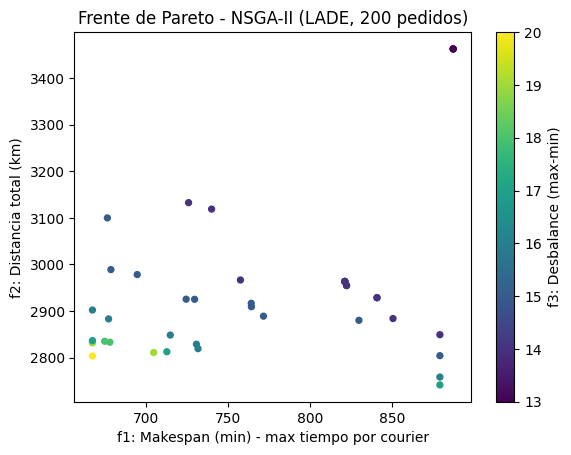

In [22]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

algorithm = NSGA2(pop_size=120)

res = minimize(
    problem,
    algorithm,
    termination=("n_gen", 250),
    seed=1,
    verbose=True,
    save_history=True
)

F = res.F
print("✅ Pareto solutions:", F.shape[0])

plt.figure()
sc = plt.scatter(F[:,0], F[:,1], c=F[:,2], s=18)
plt.xlabel("f1: Makespan (min) - max tiempo por courier")
plt.ylabel("f2: Distancia total (km)")
plt.colorbar(sc, label="f3: Desbalance (max-min)")
plt.title("Frente de Pareto - NSGA-II (LADE, 200 pedidos)")
plt.show()


In [23]:
best_f1, avg_f1 = [], []
best_f2, avg_f2 = [], []
best_f3, avg_f3 = [], []

for algo in res.history:
    # objetivos de la población de esa generación
    Fg = algo.pop.get("F")  # shape: (pop_size, 3)

    best_f1.append(Fg[:, 0].min())
    avg_f1.append(Fg[:, 0].mean())

    best_f2.append(Fg[:, 1].min())
    avg_f2.append(Fg[:, 1].mean())

    best_f3.append(Fg[:, 2].min())
    avg_f3.append(Fg[:, 2].mean())

best_f1 = np.array(best_f1); avg_f1 = np.array(avg_f1)
best_f2 = np.array(best_f2); avg_f2 = np.array(avg_f2)
best_f3 = np.array(best_f3); avg_f3 = np.array(avg_f3)

print("Generaciones registradas:", len(best_f1))


Generaciones registradas: 250


Grafica Convergencia

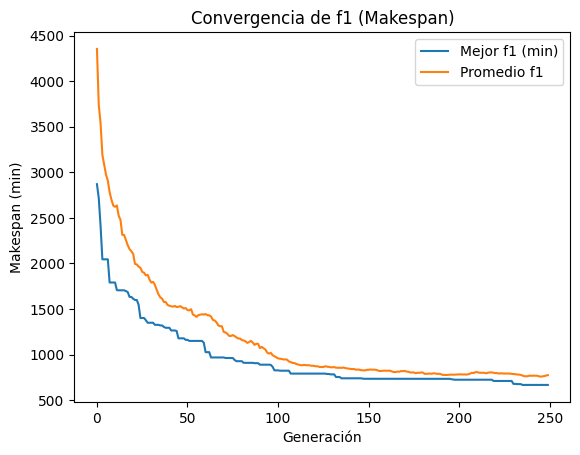

In [24]:
plt.figure()
plt.plot(best_f1, label="Mejor f1 (min)")
plt.plot(avg_f1, label="Promedio f1")
plt.xlabel("Generación")
plt.ylabel("Makespan (min)")
plt.title("Convergencia de f1 (Makespan)")
plt.legend()
plt.show()


Grafico convergencia - Ditancia total

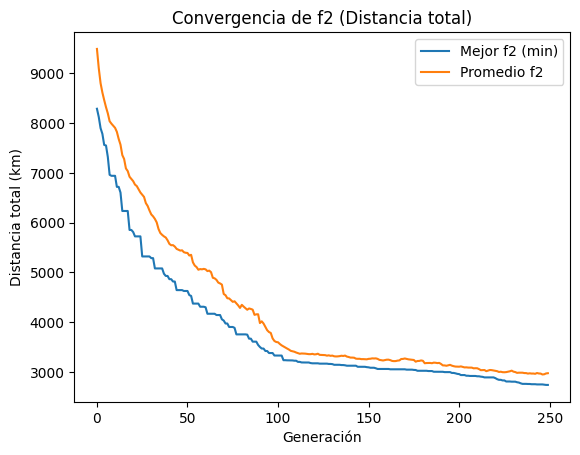

In [25]:
plt.figure()
plt.plot(best_f2, label="Mejor f2 (min)")
plt.plot(avg_f2, label="Promedio f2")
plt.xlabel("Generación")
plt.ylabel("Distancia total (km)")
plt.title("Convergencia de f2 (Distancia total)")
plt.legend()
plt.show()


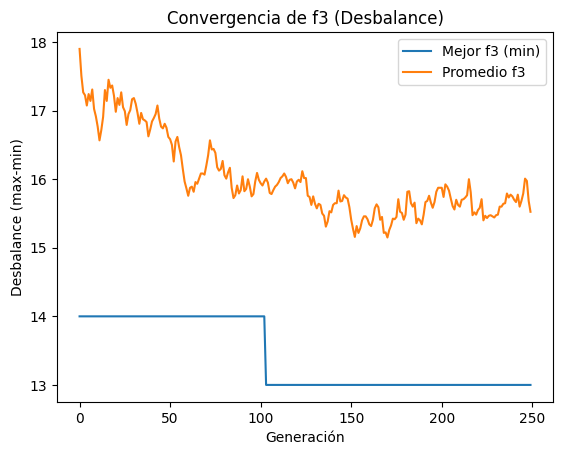

In [26]:
plt.figure()
plt.plot(best_f3, label="Mejor f3 (min)")
plt.plot(avg_f3, label="Promedio f3")
plt.xlabel("Generación")
plt.ylabel("Desbalance (max-min)")
plt.title("Convergencia de f3 (Desbalance)")
plt.legend()
plt.show()


In [27]:
window = 30
delta_f1 = best_f1[-window] - best_f1[-1]
delta_f2 = best_f2[-window] - best_f2[-1]
delta_f3 = best_f3[-window] - best_f3[-1]

print(f"Mejora en best f1 (últimas {window} gens): {delta_f1:.4f}")
print(f"Mejora en best f2 (últimas {window} gens): {delta_f2:.4f}")
print(f"Mejora en best f3 (últimas {window} gens): {delta_f3:.4f}")


Mejora en best f1 (últimas 30 gens): 43.3712
Mejora en best f2 (últimas 30 gens): 136.3285
Mejora en best f3 (últimas 30 gens): 0.0000


Grafica convergencia - desbalance

In [28]:
F = res.F.copy()

# normalizar a [0,1] cada objetivo
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-12)

# score por distancia al origen (0,0,0): menor = mejor compromiso
score = np.linalg.norm(F_norm, axis=1)

best_idx = np.argmin(score)
print("✅ Índice solución compromiso:", best_idx)
print("f1,f2,f3:", res.F[best_idx])


✅ Índice solución compromiso: 8
f1,f2,f3: [ 678.54612052 2989.00634868   15.        ]


In [29]:
best_assign = res.X[best_idx].astype(int)
instance_solution = instance.copy()
instance_solution["courier_assigned"] = best_assign

instance_solution.head()



,order_id,city,region_id,accept_time,lat,lng,ds,courier_assigned
0,5027140,Yantai,115,2020-05-01 06:19:00,37.38136,121.58688,501,1
1,5446112,Yantai,123,2020-05-01 06:22:00,37.64241,120.53291,501,12
2,6066898,Yantai,130,2020-05-01 07:02:00,37.48019,121.44580,501,13
3,3703809,Yantai,119,2020-05-01 07:03:00,36.76947,121.14968,501,2
4,5731549,Yantai,107,2020-05-01 07:08:00,37.53660,121.41415,501,11


In [30]:
counts = instance_solution["courier_assigned"].value_counts().sort_index()
print("Pedidos por courier (min/max):", counts.min(), counts.max())
counts.head()


Pedidos por courier (min/max): 5 14


,count
courier_assigned,
0,10
1,14
2,14
3,14
4,8


In [31]:
out_path = f"{RESULTS_DIR}/best_solution_orders.csv"
instance_solution.to_csv(out_path, index=False)
print("✅ Guardado:", out_path)


✅ Guardado: /content/drive/MyDrive/LADE_Evolutionary_Project/results/best_solution_orders.csv


In [32]:
df = pd.read_csv(f"{RESULTS_DIR}/best_solution_orders.csv")
tabla_asignacion = (
    df.groupby("courier_assigned")
      .size()
      .reset_index(name="num_pedidos")
      .sort_values("courier_assigned")
)

tabla_asignacion


,courier_assigned,num_pedidos
0,0,10
1,1,14
2,2,14
3,3,14
4,4,8
5,5,10
6,6,13
7,7,13
8,8,6
9,9,13


In [33]:
tabla_asignacion.to_csv(
    "tabla_asignacion_couriers.csv",
    index=False
)

In [34]:
min_pedidos = tabla_asignacion["num_pedidos"].min()
max_pedidos = tabla_asignacion["num_pedidos"].max()
balance = max_pedidos - min_pedidos

min_pedidos, max_pedidos, balance


(5, 14, 9)

Estudio de sensibilidad

In [35]:
import time
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

def run_nsga(pop_size, n_gen=250):
    algorithm = NSGA2(pop_size=pop_size)

    start = time.time()
    res = minimize(
        problem,
        algorithm,
        termination=("n_gen", n_gen),
        seed=1,
        verbose=False
    )
    elapsed = time.time() - start

    F = res.F

    return {
        "pop_size": pop_size,
        "best_f1": F[:,0].min(),
        "best_f2": F[:,1].min(),
        "best_f3": F[:,2].min(),
        "pareto_size": F.shape[0],
        "time_sec": elapsed
    }


In [36]:
results = []
for p in [60, 120, 200]:
    results.append(run_nsga(p))

import pandas as pd
df_sens = pd.DataFrame(results)
df_sens


,pop_size,best_f1,best_f2,best_f3,pareto_size,time_sec
0,60,894.290544,3562.476995,13.0,18,5.944137
1,120,667.291930,2741.335637,13.0,41,12.422976
2,200,634.642893,2571.952918,13.0,19,22.116950


In [37]:
import numpy as np

def random_assignment(dist_matrix, K, v_kmh, service_min, seed=1):
    np.random.seed(seed)

    n_orders = dist_matrix.shape[1]
    assign = np.random.randint(0, K, size=n_orders)

    dist_per = np.zeros(K)
    cnt_per = np.zeros(K, dtype=int)

    for j in range(n_orders):
        c = assign[j]
        dist_per[c] += dist_matrix[c, j]
        cnt_per[c] += 1

    min_per_km = 60.0 / v_kmh
    time_per = dist_per * min_per_km + cnt_per * service_min

    f1 = time_per.max()
    f2 = dist_per.sum()
    f3 = cnt_per.max() - cnt_per.min()

    return f1, f2, f3


In [38]:
f1_rand, f2_rand, f3_rand = random_assignment(
    dist_matrix, K, V_KM_H, SERVICE_MIN
)

print("Baseline aleatorio")
print("f1:", f1_rand)
print("f2:", f2_rand)
print("f3:", f3_rand)


Baseline aleatorio
f1: 3564.316592197721
f2: 8793.040115945218
f3: 11
